In [107]:
import torch
import os
import numpy as np
import torchvision
import torch.nn as nn
import numpy as np
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
from torchvision import utils
import torchvision.transforms as T
from torch import optim

path = "/home/kevin/Pictures/style_transfer/"

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Images
Load and resize the images to be used

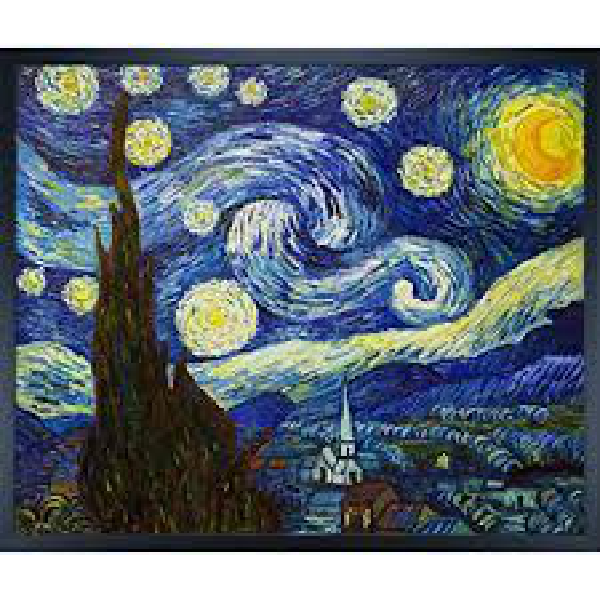

In [108]:
# Images
style_img_path = os.path.join(path, "starry_night.jpg")
content_img_path = os.path.join(path, "DSC_0206.JPG")

# Load images
style_img = Image.open(style_img_path)
content_img = Image.open(content_img_path)

# Resize
img_size = (600, 600)
style_img = style_img.resize(img_size)
content_img = content_img.resize(img_size)
style_img

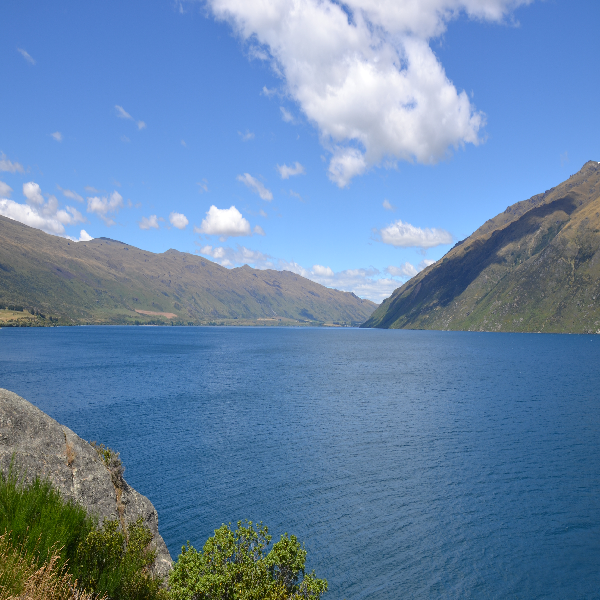

In [109]:
content_img

In [110]:
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
normalize = T.Normalize(mean.tolist(), std.tolist())
unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

In [111]:
# Transform image to pytorch
transform = T.Compose([T.Resize(img_size[0], img_size[1]),
                       T.ToTensor(),
                       normalize])
style_img = torch.unsqueeze(transform(style_img), 0)
content_img = torch.unsqueeze(transform(content_img), 0)

# Model
Load a VGG model

In [112]:
model = torchvision.models.vgg19(pretrained=True)

# Freeze model
for param in model.parameters():
    param.requires_grad = False
    
model.to(device).eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [113]:
# Replace Max-pooling with average pooling
for i, l in enumerate(model.features):
    if isinstance(l, torch.nn.MaxPool2d):
        model.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        


In [114]:
def get_layer_activations(img, model, layers=None):
    """
    Return the activations of a number of layers
    """
    if layers is None:
        layers = {'0': 'conv1_1','5': 'conv2_1',
                  '10': 'conv3_1', '19': 'conv4_1',
                  '21': 'conv4_2', '28': 'conv5_1'}
    features = {}
    x = img
    for name, layer in enumerate(model.features):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    
    return features

def compute_gram(img):
    """
    Compute the Gram matrix of an image
    """
    _, d, h, w = img.shape
    img_tensor = img.view(d, h*w)
    img_gram = torch.mm(img_tensor, img_tensor.t())
    return img_gram
    
def tensor_to_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

def tensor_to_pil(tensor):
    """
    Create unnormalized PIL image from output tensor
    """
    image = tensor.to("cpu").clone().detach()
    image = torch.squeeze(image, 0)
    image = unnormalize(image)
    image = torch.clamp(test, 0,1)
    image = T.ToPILImage()(image)
    return image

In [115]:
# Images to device
style_img = style_img.to(device)
content_img = content_img.to(device)

# Get features
style_feats = get_layer_activations(style_img, model)
content_feats = get_layer_activations(content_img, model)

# Style gram matrices
style_grams = {layer: compute_gram(style_feats[layer]) for layer in style_feats}

In [116]:
# White noise image
target = torch.randn_like(content_img).requires_grad_(True).to(device)

In [117]:
style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1e4
style_weight = 1e2

optimizer = optim.Adam([target], lr=0.01)

In [118]:
for i in range(400):
    optimizer.zero_grad()
    target_features = get_layer_activations(target, model)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_feats['conv4_2']) ** 2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = compute_gram(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_loss / (d * h * w)
        
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward(retain_graph=True)
        optimizer.step()

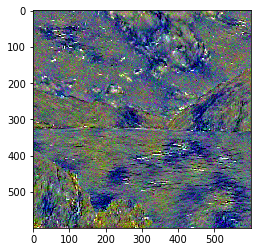

In [119]:
plt.imshow(tensor_to_image(target))

In [95]:
target

tensor([[[[-0.1584, -0.4474, -0.6158,  ..., -0.5479, -0.8068, -0.1217],
          [-0.2356, -0.6999,  0.4946,  ..., -1.2278, -0.1803, -1.0074],
          [-0.0023, -0.2861, -0.6616,  ..., -0.3197, -0.2729, -0.7659],
          ...,
          [ 0.3234,  0.1524,  0.7417,  ..., -0.1106, -0.3788, -1.4751],
          [ 0.2276, -0.2493, -0.4321,  ..., -0.3083, -1.0664, -0.4696],
          [-0.2050,  0.1369,  0.0728,  ..., -1.2295, -0.1702, -0.4057]],

         [[-0.0225, -0.4823,  0.4601,  ...,  0.7244, -0.5720, -1.4650],
          [-0.3003,  0.3591, -1.0527,  ...,  0.0947, -1.5137,  0.1698],
          [ 0.8317, -0.7895,  0.2345,  ..., -0.6304, -0.5494, -0.1827],
          ...,
          [ 0.8263, -0.1145, -0.2727,  ..., -1.5907, -0.7921, -0.3853],
          [ 0.2608, -0.4173, -0.2382,  ..., -0.9617, -0.1968, -0.4578],
          [ 1.0078, -0.7843, -0.5665,  ...,  0.8439, -0.2516, -0.3565]],

         [[-1.4192, -0.8393, -1.4367,  ..., -1.0898, -1.2883, -0.4842],
          [-0.1503, -0.5784,  

In [104]:
test = target.clone().to("cpu").detach()
test = torch.squeeze(test, 0)
#test = T.ToPILImage()(test)
test = unnormalize(test)
test = torch.clamp(test, 0,1)
test = T.ToPILImage()(test)

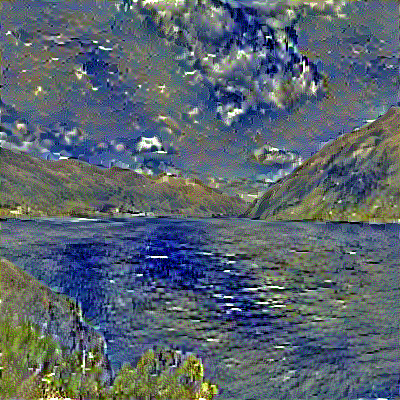

In [105]:
test

In [25]:
test = unnormalize(target)

test = T.ToPILImage()(test)

test = target.clone()
test = test.to("cpu").detach()
test = torch.squeeze(test, 0)
test.shape

T.ToPILImage()(test)

TypeError: Input type float64 is not supported

In [15]:
test = target.copy()

def tensor_to_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

def tensor_to_pil(tensor)
    image = tensor.to("cpu").clone()

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [34]:
test = target.clone().to("cpu").detach()
test = torch.squeeze(test, 0)
test = test *  torch.Tensor((0.229, 0.224, 0.225)) + torch.Tensor((0.485, 0.456, 0.406))

RuntimeError: The size of tensor a (800) must match the size of tensor b (3) at non-singleton dimension 2

In [35]:
mean = torch.tensor([1, 2, 3], dtype=torch.float32)
std = torch.tensor([2, 2, 2], dtype=torch.float32)

normalize = T.Normalize(mean.tolist(), std.tolist())

unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())